# Libraries

In [ ]:
## Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
import sys
from pathlib import Path
from tqdm import tqdm

project_root = Path("/home/benedetti/PL")  

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## PyTorch
import torch

from PL.model.model import TwoBodiesModel
from PL.dataset.random_features import RandomDatasetPowerLaw, GeneralDataset

from PL.training.training_RF import train_model

device = torch.device("cuda:1")

data_PATH = "./data"


# Parameters

In [2]:
# Nature of variables and loss
d=1
spin_type = "vector"

pick_biased = True

# Step
n = 100

L=3
eta=2.
alpha_P = 10.
alpha_D = 0.1

N = 1000
P = int(alpha_P*N)
D = int(alpha_D*N)
d = 1
seed = 100


dataset = RandomDatasetPowerLaw(P, N, D, d, eta=eta, L=L, seed=seed, spin_type=spin_type, coefficients="binary", shift=0, pick_biased=pick_biased)
model  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)
xi = dataset.xi.to(device)
f =  dataset.f.to(device)
model.Hebb(xi, "Tensorial")
x = f.clone()
for i_n in range(n):
    x = model.dyn_step(x)
overlap_k = torch.abs(torch.einsum("kia,kia->k", f, x))/N

print(overlap_k[:100])

def count_overlaps_above_threshold(overlaps, thr):
    count = 0
    for overlap in overlaps:
        if overlap > thr:
            count += 1
        else:
            break  # Stop at the first overlap that is lower than the threshold
    return count

num_stable_f = count_overlaps_above_threshold(overlap_k, 0.99)

print(num_stable_f)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0520, 0.0280,
        0.0520, 0.0340, 0.0420, 0.0200, 0.0480, 0.0240, 0.0600, 0.0500, 0.0300,
        0.0160, 0.0440, 0.0380, 0.0440, 0.0380, 0.0200, 0.0340, 0.0540, 0.0420,
        0.0260, 0.0640, 0.0240, 0.0240, 0.0240, 0.0260, 0.0480, 0.0260, 0.0900,
        0.0500, 0.0180, 0.0300, 0.0220, 0.0740, 0.0440, 0.0380, 0.1280, 0.0780,
        0.0360, 0.0880, 0.0080, 0.0500, 0.0380, 0.0060, 0.0840, 0.0120, 0.0860,
        0.0500, 0.0140, 0.0300, 0.0320, 0.0600, 0.0920, 0.0720, 0.0300, 0.0460,
        0.0180, 0.0580, 0.0140, 0.0400, 0.0180, 0.0140, 0.0220, 0.0280, 0.0160,
        0.0360, 0.0420, 0.0160, 0.0080, 0.0480, 0.0420, 0.0220, 0.0460, 0.0360,
        0.0300, 0.0600, 0.0960, 0.0200, 0.0520, 0.0080, 0.1140, 0.0300, 0.0260,
        0.0140, 0.0840, 0.0740, 0.0300, 0.0180, 0.0420, 0.0560, 0.0540, 0.0600,
        0.0200], device='cuda:1')
7


In [3]:
P_hat = 20

stable_features = torch.arange(0, num_stable_f)
unstable_features = torch.arange(num_stable_f, D)

stable_xi = dataset.get_generalization_selected_features(P_hat, stable_features, L=L)
unstable_xi = dataset.get_generalization_selected_features(P_hat, unstable_features, L=L)

stable_xi = stable_xi.to(device)
unstable_xi = unstable_xi.to(device)

x = stable_xi.clone()

for i_n in range(n):
    x = model.dyn_step(x)

overlap_stable = torch.abs(torch.einsum("kia,kia->k", stable_xi, x))/N
overlap_stable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Stable:", overlap_stable)
print("F Stable:", overlap_stable_f)

x = unstable_xi.clone()

for i_n in range(n):
    x = model.dyn_step(x)

overlap_unstable = torch.abs(torch.einsum("kia,kia->k", unstable_xi, x))/N

print("Unstable:", overlap_unstable)

Stable: tensor([0.5520, 0.5200, 0.4820, 0.4840, 0.5040, 0.5140, 0.0460, 0.5080, 0.5060,
        0.5200, 0.5180, 0.5100, 0.5040, 0.4760, 0.5040, 0.4720, 0.4880, 0.4780,
        0.4780, 0.5100], device='cuda:1')
F Stable: tensor([[0.0140, 1.0000, 1.0000,  ..., 0.0140, 1.0000, 0.0100],
        [0.0320, 0.0100, 0.0100,  ..., 0.0320, 0.0100, 1.0000],
        [1.0000, 0.0140, 0.0140,  ..., 1.0000, 0.0140, 0.0320],
        ...,
        [0.0340, 0.0160, 0.0160,  ..., 0.0340, 0.0160, 0.0540],
        [0.0060, 0.0600, 0.0600,  ..., 0.0060, 0.0600, 0.0180],
        [0.0140, 0.0200, 0.0200,  ..., 0.0140, 0.0200, 0.0220]],
       device='cuda:1')
Unstable: tensor([0.0040, 0.0200, 0.0520, 0.0480, 0.0380, 0.0120, 0.0180, 0.0440, 0.0120,
        0.0280, 0.0180, 0.0200, 0.0440, 0.0840, 0.1040, 0.0340, 0.0080, 0.0300,
        0.0620, 0.0520], device='cuda:1')


# PL

## One training

In [ ]:
# Model and training
l=1.
lr = 0.1*N

epochs=10000
valid_every = 2
max_grad = 20.
init_overlap = 1.
n=100

loss_type = "CE"
l2 = False
alpha=1.

In [15]:
model_PL  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)

optimizer = torch.optim.SGD(model_PL.parameters(), lr=lr)

xi = dataset.xi.to(device)
f =  dataset.f.to(device)
#model_PL.Hebb(xi, "Tensorial")

P_hat = 100

dataset_f = GeneralDataset(D, dataset.f)
xi_generalization = dataset.get_generalization(P_hat, L=L)
dataset_generalization = GeneralDataset(P_hat, xi_generalization)
batch_size = P
batch_size_f = D

model2 = TwoBodiesModel(N, d, spin_type=spin_type, device=device)
model2.to(device)
model2.Hebb(dataset.xi.to(device), 'Tensorial')  # Applying the Hebb rule
J2 = model2.J.squeeze().cpu().detach().numpy()
norm_J2 = np.linalg.norm(J2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
dataloader_f = torch.utils.data.DataLoader(dataset_f, batch_size=batch_size_f, shuffle=False, drop_last=False, num_workers=2)
dataloader_generalization = torch.utils.data.DataLoader(dataset_generalization, batch_size=P_hat, shuffle=False, drop_last=False, num_workers=2)

epochs_to_save = [10,50,200]
save = True
print("epochs:{}  lr:{}  max_norm:{}  init_overlap:{}  n:{}  l:{}".format(epochs, lr, max_grad, init_overlap, n, l))


epochs:10000  lr:100.0  max_norm:20.0  init_overlap:1.0  n:100  l:1.0


In [16]:
model_name_base = "PL_{}_{}_GD_PW_eta{}_N_{}_P_{}_D{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, eta, N, P, D, l, epochs, lr, l2)
model_name = model_name_base + ".pth"
print(model_name)

PL_vector_CE_GD_PW_eta2.0_N_4000_P_40000_D400_l_1.0_epochs10000_lr100.0_l2False.pth


In [17]:
train_model(
    model_PL, dataloader, dataloader_f, dataloader_generalization, epochs, 
    lr, max_grad, device, data_PATH, init_overlap, 
    n, l, optimizer, J2, norm_J2, valid_every, epochs_to_save, model_name_base, save, l2, alpha,loss_type
)

# epoch lambda train_loss learning_rate train_metric features_metric generalization_metric // // // norm_x


100 0.5753056406974792 0.015420211479067802 100.0 0.9735081 0.21120441 0.9614801 0.9911869 0.46301582 0.98037004 12649.1103515625
200 0.6233677268028259 0.009490774013102055 100.0 0.98328125 0.24035066 0.9662651 0.99598116 0.5628047 0.98706007 12649.1103515625
300 0.6683117151260376 0.007116770837455988 100.0 0.9873645 0.27089942 0.96627015 0.99768007 0.6149022 0.9900951 12649.1103515625
400 0.7081565856933594 0.0057362401857972145 100.0 0.9898301 0.29536688 0.9711601 0.9985752 0.64749724 0.99218017 12649.1103515625
500 0.743388831615448 0.004809495992958546 100.0 0.9917001 0.3155619 0.97118014 0.9991062 0.6697722 0.99329513 12649.1103515625


KeyboardInterrupt: 

In [9]:
x = f.clone()
for i_n in range(n):
    x = model_PL.dyn_step(x)
overlap_k = torch.abs(torch.einsum("kia,kia->k", f, x))/N

print(overlap_k[:100])

def count_overlaps_above_threshold(overlaps, thr):
    count = 0
    for overlap in overlaps:
        if overlap > thr:
            count += 1
        else:
            break  # Stop at the first overlap that is lower than the threshold
    return count

num_stable_f = count_overlaps_above_threshold(overlap_k, 0.99)

print(num_stable_f)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0240, 0.9980, 0.9980, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9940, 1.0000, 0.0000, 1.0000,
        0.0520, 0.0780, 0.0000, 0.0400, 1.0000, 0.0140, 0.9960, 1.0000, 0.0760,
        0.9980, 0.0040, 1.0000, 0.0340, 1.0000, 0.0420, 0.9860, 0.0220, 0.0360,
        0.0780, 0.0680, 0.0960, 1.0000, 0.9980, 0.0300, 0.9960, 0.0060, 0.0400,
        0.0360, 0.0840, 0.0740, 0.9860, 0.0120, 0.0600, 0.0620, 0.0400, 0.0280,
        0.0840], device='cuda:1')
48


In [10]:
P_hat = 20

num_stable_f = 10

stable_features = torch.arange(0, num_stable_f)
unstable_features = torch.arange(num_stable_f, D)

stable_xi = dataset.get_generalization_selected_features(P_hat, stable_features, L=L)
unstable_xi = dataset.get_generalization_selected_features(P_hat, unstable_features, L=L)

stable_xi = stable_xi.to(device)
unstable_xi = unstable_xi.to(device)

x = stable_xi.clone()

for i_n in range(n):
    x = model_PL.dyn_step(x)

overlap_stable = torch.abs(torch.einsum("kia,kia->k", stable_xi, x))/N
overlap_stable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Stable:", overlap_stable)
print("F Stable:", overlap_stable_f[:,0])

x = unstable_xi.clone()

for i_n in range(n):
    x = model_PL.dyn_step(x)

overlap_unstable = torch.abs(torch.einsum("kia,kia->k", unstable_xi, x))/N
overlap_unstable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Unstable:", overlap_unstable)
print("F Unstable:", overlap_unstable_f[:,1])

Stable: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:1')
F Stable: tensor([0.0300, 0.0520, 0.0160, 0.4600, 0.0460, 0.4740, 0.5580, 0.0140, 0.0380,
        0.0120, 0.0140, 0.0000, 0.0100, 0.0280, 0.0020, 0.0160, 0.0020, 0.0200,
        0.0260, 0.0500, 0.0380, 0.0520, 0.0300, 0.0260, 0.0380, 0.0600, 0.0240,
        0.0200, 0.0380, 0.0620, 0.0080, 0.0300, 0.0280, 0.0100, 0.0440, 0.0420,
        0.0520, 0.0360, 0.0240, 0.0680, 0.0020, 0.0220, 0.0120, 0.0240, 0.0040,
        0.0120, 0.0540, 0.0180, 0.0220, 0.0520, 0.0200, 0.0100, 0.0380, 0.0040,
        0.0220, 0.0720, 0.0040, 0.0740, 0.0360, 0.0320, 0.0020, 0.0320, 0.0160,
        0.0500, 0.0080, 0.0740, 0.0080, 0.0160, 0.0840, 0.0720, 0.0300, 0.0420,
        0.0620, 0.0180, 0.0100, 0.0060, 0.0020, 0.0200, 0.0520, 0.0440, 0.0140,
        0.0480, 0.0360, 0.0940, 0.0120, 0.0160, 0.0020, 0.0300, 0.0080, 0.0680,
        0.0160, 0.0140, 0.0040, 0.0740, 0.0120, 0.0000, 0.0020, 0.02

In [11]:
P_hat = 20

xi_gen = dataset.get_generalization(P_hat, L=L)

xi_gen = xi_gen.to(device)

x = xi_gen.clone()

for i_n in range(n):
    x = model_PL.dyn_step(x)

overlap_stable = torch.abs(torch.einsum("kia,kia->k", xi_gen, x))/N
overlap_stable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Stable:", overlap_stable)
print("F Stable:", overlap_stable_f[:,2])

Stable: tensor([1.0000, 1.0000, 0.4980,  ..., 1.0000, 1.0000, 1.0000], device='cuda:1')
F Stable: tensor([1.0000, 0.0100, 0.0140, 0.0060, 0.0320, 0.0280, 0.0320, 0.0520, 0.0280,
        0.0140, 0.0040, 0.0420, 0.0200, 0.0220, 0.0240, 0.0180, 0.0080, 0.0300,
        0.0160, 0.0440, 0.0160, 0.0060, 0.0080, 0.0200, 0.0080, 0.0540, 0.0420,
        0.0260, 0.0640, 0.0240, 0.0020, 0.0240, 0.0260, 0.0480, 0.0260, 0.0160,
        0.0500, 0.0180, 0.0300, 0.0220, 0.0080, 0.0440, 0.0380, 0.0260, 0.0020,
        0.0020, 0.0880, 0.0080, 0.0240, 0.0380, 0.0060, 0.0200, 0.0120, 0.0860,
        0.0040, 0.0140, 0.0300, 0.0320, 0.0020, 0.0460, 0.0720, 0.0300, 0.0220,
        0.0040, 0.0580, 0.0000, 0.0140, 0.0180, 0.0140, 0.0220, 0.0280, 0.0160,
        0.0360, 0.0120, 0.0160, 0.0080, 0.0160, 0.0420, 0.0220, 0.0180, 0.0360,
        0.0300, 0.0300, 0.0960, 0.0020, 0.0020, 0.0080, 0.0160, 0.0300, 0.0260,
        0.0140, 0.0840, 0.0740, 0.0040, 0.0180, 0.0420, 0.0560, 0.0160, 0.0600,
        0.0200], devic

## Many trainings

In [22]:
# Step
n = 100
d=1
L=3
eta=1.5
alpha_D = 0.5

In [23]:
# Model and training
l=1.

epochs=100
valid_every = 100
max_grad = 20.
init_overlap = 1.
n=100

#training
loss_type = "CE"
l2 = False
alpha=1.

epochs_to_save = [10000]
save = False

In [24]:
def compute_overlap_array_model(model, dataset, N):

    f = dataset.f.to(device)

    x = f.clone()

    for i_n in range(n):
        x = model.dyn_step(x)

    overlap_k = torch.abs(torch.einsum("kia,kia->k", f, x))/N

    return overlap_k.cpu().numpy()



In [ ]:
def train_single_model(N, P, D):
    lr = 0.05*N

    optimizer = torch.optim.SGD(model_PL.parameters(), lr=lr)
    
    P_hat = 10
    
    dataset_f = GeneralDataset(D, dataset.f)
    xi_generalization = dataset.get_generalization(P_hat, L=L)
    dataset_generalization = GeneralDataset(P_hat, xi_generalization)
    batch_size = P
    batch_size_f = D
    
    model2 = TwoBodiesModel(N, d, spin_type=spin_type, device=device)
    model2.to(device)
    model2.Hebb(dataset.xi.to(device), 'Tensorial')  
    J2 = model2.J.squeeze().cpu().detach().numpy()
    norm_J2 = np.linalg.norm(J2)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
    dataloader_f = torch.utils.data.DataLoader(dataset_f, batch_size=batch_size_f, shuffle=False, drop_last=False, num_workers=2)
    dataloader_generalization = torch.utils.data.DataLoader(dataset_generalization, batch_size=P_hat, shuffle=False, drop_last=False, num_workers=2)

    train_model(
        model_PL, dataloader, dataloader_f, dataloader_generalization, epochs, 
        lr, max_grad, device, data_PATH, init_overlap, 
        n, l, optimizer, J2, norm_J2, valid_every, epochs_to_save, model_name_base, save, l2, alpha,loss_type, verbose=False
    )

    cuda_cleanup(dataset_f, dataset_generalization,
     dataloader, dataloader_f, dataloader_generalization,
     optimizer)
    
def cuda_cleanup(*objs):
    for o in objs:
        try:
            del o
        except Exception:
            pass
    gc.collect()
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

# Varying $\alpha_P$

In [26]:
N = 2000

#alpha_P_arr = np.array([0.01,0.1,1.])
alpha_P_arr = np.array([0.0316,0.316,3.16,31.6])
seeds_arr = np.arange(100, 150)

to_save = np.empty((len(alpha_P_arr), len(seeds_arr)), dtype=object)


for i_s, seed in tqdm(enumerate(seeds_arr)):
    for i_a, alpha_P in enumerate(alpha_P_arr):
        P = int(alpha_P*N)
        D = int(alpha_D*N)
        
        dataset = RandomDatasetPowerLaw(P, N, D, d, eta=eta, L=L, seed=seed, spin_type=spin_type, coefficients="binary", shift=0, pick_biased=pick_biased)
        model_PL  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)

        model_name_base = "."
        
        train_single_model(N, P, D)
        
        to_save[i_a, i_s] = compute_overlap_array_model(model_PL, dataset, N) 

        cuda_cleanup(model_PL)

50it [3:19:48, 239.77s/it]


In [27]:
means = np.empty(len(alpha_P_arr), dtype=object)
std = np.empty(len(alpha_P_arr), dtype=object)

for i_a, alpha_P in enumerate(alpha_P_arr):
    D = int(alpha_D*N)
    arr = np.zeros((len(seeds_arr), D))
    for i_s in range(len(seeds_arr)):
        arr[i_s] = to_save[i_a, i_s]
    means[i_a] = arr.mean(axis=0)
    std[i_a] = arr.std(axis=0)

fname = "PL_curves_eta{}_N{}_alpha_D{}_L{}_epochs{}_varying_alpha_P_BIG".format(eta, N, alpha_D,L,epochs)

final_dict = {
    "means": means,
    "std": std,
    "N": N,
    "alpha_D": alpha_D,
    "alpha_P_arr": alpha_P_arr,
    "seeds_arr": seeds_arr,
    "eta": eta
}

np.savez("/home/benedetti/RF_power_law/data/"+fname, **final_dict )

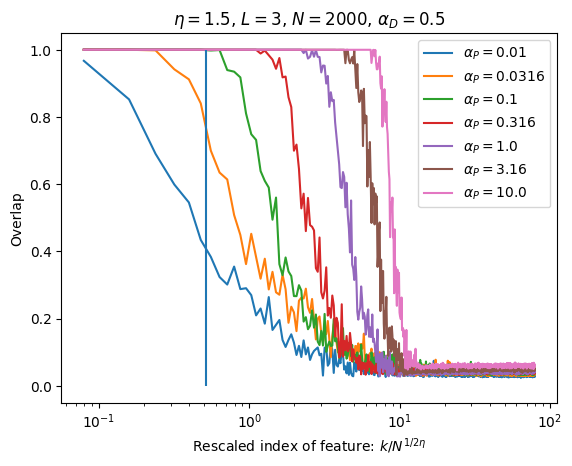

In [28]:
fname = "PL_curves_eta{}_N{}_alpha_D{}_L{}_epochs{}_varying_alpha_P.npz".format(eta, N, alpha_D, L,epochs)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)

mean_arr = saved_dict["means"]
std_arr = saved_dict["std"]
alpha_P_array = saved_dict["alpha_P_arr"]
aD =  saved_dict["alpha_D"]
N =  saved_dict["N"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

fname = "PL_curves_eta{}_N{}_alpha_D{}_L{}_epochs{}_varying_alpha_P_BIG.npz".format(eta, N, alpha_D, L,epochs)
saved_dict_BIG = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)

mean_arr_BIG = saved_dict_BIG["means"]
std_arr_BIG = saved_dict_BIG["std"]
alpha_P_array_BIG = saved_dict_BIG["alpha_P_arr"]
aD_BIG =  saved_dict_BIG["alpha_D"]
N_BIG =  saved_dict_BIG["N"]
eta_value_BIG = saved_dict_BIG["eta"]
s_arr_BIG = saved_dict_BIG["seeds_arr"]

for i_a, alpha_P in enumerate(alpha_P_array):
    P = int(alpha_P*N)
    D = int(aD*N)
    #plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))
    plt.plot(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_a], label=r"$\alpha_P={}$".format(alpha_P))
    alpha_P_BIG = alpha_P_array_BIG[i_a]
    plt.plot(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr_BIG[i_a], label=r"$\alpha_P={}$".format(alpha_P_BIG))


fname = "PL_curves_eta{}_alpha_P{}_alpha_D{}_L{}_epochs{}.npz".format(eta, 10., alpha_D, L,epochs)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)

mean_arr = saved_dict["means"]
std_arr = saved_dict["std"]
N_array = saved_dict["N_arr"]
aD =  saved_dict["alpha_D"]
aP =  saved_dict["alpha_P"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

plt.plot(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_a], label=r"$\alpha_P={}$".format(aP))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $N={N}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()
plt.show()

# Varying N

In [8]:
N_arr = np.array([8000])
seeds_arr = np.arange(100, 150)

to_save = np.empty((len(N_arr), len(seeds_arr)), dtype=object)


for i_s, seed in tqdm(enumerate(seeds_arr)):
    for i_N, N in enumerate(N_arr):
        P = int(alpha_P*N)
        D = int(alpha_D*N)
        
        dataset = RandomDatasetPowerLaw(P, N, D, d, eta=eta, L=L, seed=seed, spin_type=spin_type, coefficients="binary", shift=0, pick_biased=pick_biased)
        model_PL  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)

        model_name_base = "."
        
        train_single_model(N, P, D)
        
        to_save[i_N, i_s] = compute_overlap_array_model(model_PL, dataset, N) 

        cuda_cleanup(model_PL)


50it [9:39:41, 695.62s/it]


In [9]:
means = np.empty(len(N_arr), dtype=object)
std = np.empty(len(N_arr), dtype=object)

for i_N, N in enumerate(N_arr):
    D = int(alpha_D*N)
    arr = np.zeros((len(seeds_arr), D))
    for i_s in range(len(seeds_arr)):
        arr[i_s] = to_save[i_N, i_s]
    means[i_N] = arr.mean(axis=0)
    std[i_N] = arr.std(axis=0)

fname = "PL_curves_eta{}_alpha_P{}_alpha_D{}_L{}_epochs{}_big_N".format(eta, alpha_P, alpha_D,L,epochs)

final_dict = {
    "means": means,
    "std": std,
    "alpha_P": alpha_P,
    "alpha_D": alpha_D,
    "N_arr": N_arr,
    "seeds_arr": seeds_arr,
    "eta": eta
}

np.savez("/home/benedetti/RF_power_law/data/"+fname, **final_dict )

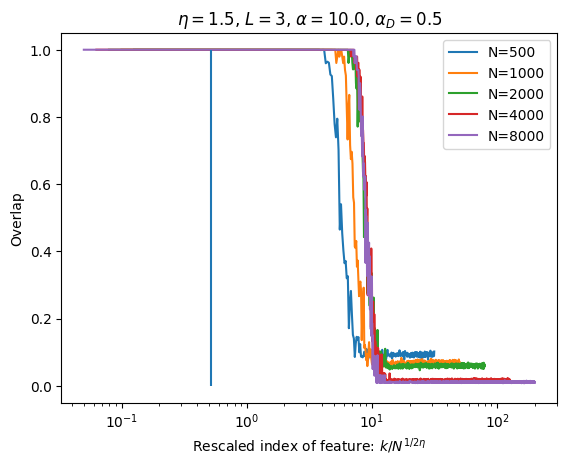

In [11]:
fname = "PL_curves_eta{}_alpha_P{}_alpha_D{}_L{}_epochs{}.npz".format(eta, alpha_P, alpha_D, L,epochs)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)

mean_arr = saved_dict["means"]
std_arr = saved_dict["std"]
N_array = saved_dict["N_arr"]
aD =  saved_dict["alpha_D"]
aP =  saved_dict["alpha_P"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    #plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))
    plt.plot(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], label="N={}".format(N))


fname_big = "PL_curves_eta{}_alpha_P{}_alpha_D{}_L{}_epochs{}_big_N.npz".format(eta, alpha_P, alpha_D, L,epochs)
saved_dict_big = np.load("/home/benedetti/RF_power_law/data/"+fname_big, allow_pickle=True)


mean_arr = saved_dict_big["means"]
std_arr = saved_dict_big["std"]
N_array = saved_dict_big["N_arr"]
aD =  saved_dict_big["alpha_D"]
aP =  saved_dict_big["alpha_P"]
eta_value = saved_dict_big["eta"]
s_arr = saved_dict_big["seeds_arr"]

for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    #plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))
    plt.plot(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N],  label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()
plt.show()

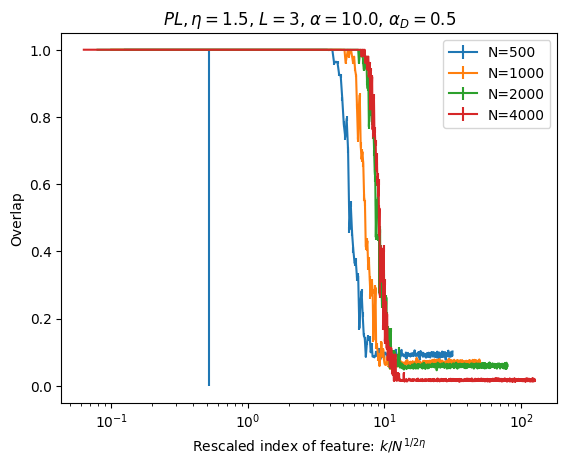

In [ ]:
fname = "PL_curves_eta{}_alpha_P{}_alpha_D{}_L{}_epochs{}.npz".format(eta, alpha_P, alpha_D, L, epochs)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)


mean_arr = saved_dict["means"]
std_arr = saved_dict["std"]
N_array = saved_dict["N_arr"]
aD =  saved_dict["alpha_D"]
aP =  saved_dict["alpha_P"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$PL, \eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()

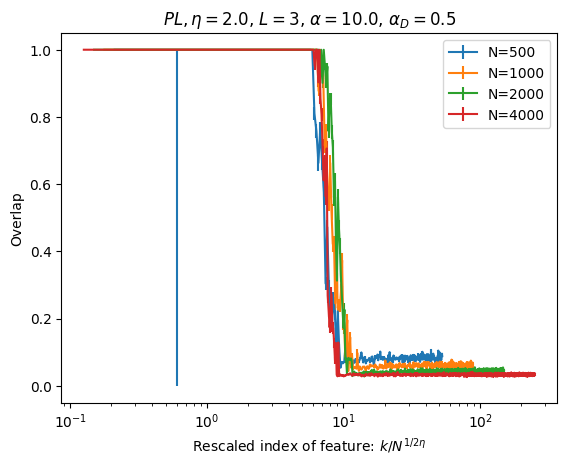

In [24]:
fname = "PL_curves_eta{}_alpha_P{}_alpha_D{}_L{}_epochs{}.npz".format(eta, alpha_P, alpha_D, L, epochs)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)


mean_arr = saved_dict["means"]
std_arr = saved_dict["std"]
N_array = saved_dict["N_arr"]
aD =  saved_dict["alpha_D"]
aP =  saved_dict["alpha_P"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$PL, \eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()

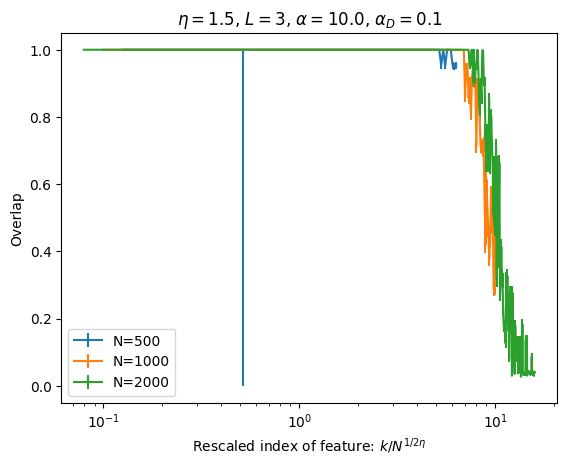

In [11]:
fname = "PL_curves_eta{}_alpha_P{}_alpha_D{}_L{}.npz".format(eta, alpha_P, alpha_D, L)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)


mean_arr = saved_dict["means"]
std_arr = saved_dict["std"]
N_array = saved_dict["N_arr"]
aD =  saved_dict["alpha_D"]
aP =  saved_dict["alpha_P"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()